In [1]:
import os
from tqdm import tqdm
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sde_model import SDE
from utils import gaussian_nll, gen_data

In [2]:
x_dist_std = 10
source_fn = lambda x: 0.004*x*x
target_fn = lambda x: 0
device = "cpu"
exp_name = "quad_line"
use_x_dist = False

x_dist_std = 10
source_fn = lambda x: torch.cos(x)
target_fn = lambda x: torch.sin(x)
device = "cpu"
exp_name = "cos_sin"
use_x_dist = True

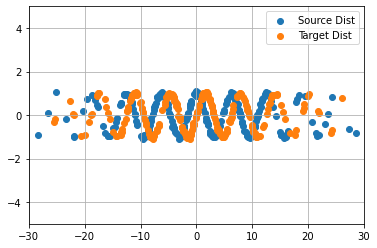

In [3]:
loaders = gen_data(x_dist_std,
                   source_fn,
                   target_fn,
                   source_std=0.05,
                   target_std=0.05,
                   num_points=1024,
                   batch_size=256)

points2 = next(iter(loaders['source'])).numpy()
plt.scatter(points2[:,0], points2[:,1], label="Source Dist")

points = next(iter(loaders['target'])).numpy()
plt.scatter(points[:,0], points[:,1], label="Target Dist")
plt.xlim(-30,30)
plt.ylim(-5,5)
plt.legend()
plt.grid()
plt.show()

In [4]:
def target_neg_log_prob(points):
    x = points[:, 0]
    y = points[:, 1]
    gt = target_fn(x)

    loss_d0 = gaussian_nll(0, np.log(x_dist_std**2), x)
    loss_d1 = gaussian_nll(gt, np.log(0.05), y)

    total_loss = loss_d1
    if use_x_dist:
        total_loss += loss_d0
        
    return total_loss

sde = SDE(10)

optimizer = torch.optim.Adam(sde.parameters(), lr=8e-4)
sde.to(device)

for epoch in tqdm(range(100)):
    for batch_idx, (data) in enumerate(loaders['source']):
        data = data.float().to(device)
        ys = sde.forward(data, 0, dt=1e-1)

        loss = target_neg_log_prob(ys[-1]).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

os.makedirs('plots', exist_ok=True)
os.makedirs(f'plots/{exp_name}', exist_ok=True)

curr_points = loaders["source"].dataset.to(device)

for i in range(0, 10):
    plt.scatter(curr_points.detach().cpu().numpy()[:,0], curr_points.detach().cpu().numpy()[:,1], c='b')
    plt.grid(True)
    plt.xlim(-30, 30)
    plt.ylim(-2, 2)

    plt.savefig(f'plots/{exp_name}/frame_{i:03d}.png')
    plt.close()  # Close the plot to avoid display

    curr_points = sde.forward(curr_points, 1, dt=1e-1)[-1]

100%|██████████| 100/100 [03:08<00:00,  1.89s/it]
